In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
# === LOAD MNIST ===
#Load CIFAR
DATA_FOLDER = './data/'
BATCH_SIZE = 128
print("Load MNIST... ", end="")
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root=DATA_FOLDER, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_FOLDER, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
ALL_TRAIN_LEN = len(train_dataset)
ALL_TEST_LEN = len(test_dataset)
all_train_loader = DataLoader(train_dataset, batch_size=ALL_TRAIN_LEN, shuffle=True)
all_test_loader = DataLoader(test_dataset, batch_size=ALL_TEST_LEN, shuffle=False)
print("done.")

Load MNIST... done.


In [8]:
# @title Utils functions and initialization scripts
def plot_cum_variance_explained(pca, n_pcs):
    plt.figure(figsize=(3, 2))
    plt.title("Cumulative explained variance")
    plt.plot(range(1, n_pcs + 1), np.cumsum(pca.explained_variance_ratio_), "o-")
    plt.xlabel("PCs")
    plt.ylabel("% explained variance")
    plt.show()


def plot_image_samples(images, n_imgs, fig_title=""):
    """Plot some samples
    Args:
        n_imgs: (int) number of images to be plotted.
    """
    plt.figure(figsize=(10, 3))
    plt.title(fig_title)
    plt.box(False)
    plt.tick_params(left=False, right=False, labelleft=False,
                    labelbottom=False, bottom=False)
    for img_i in range(n_imgs):
        plt.subplot(int(np.ceil(30 / 7)), 7, 1 + img_i)
        plt.imshow(images[img_i], cmap='gray_r')
        plt.tick_params(left=False, right=False, labelleft=False,
                        labelbottom=False, bottom=False)


def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss", marker='o')
  plt.plot(test_losses, label="Test Loss", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss per Epoch")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy", marker='o')
  plt.plot(test_accuracies, label="Test Accuracy", marker='o')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy per Epoch")
  plt.legend()
  plt.tight_layout()
  plt.show()

In [9]:
# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## PCA on MNIST

In [10]:
all_train_iter, all_test_iter = iter(all_train_loader), iter(all_test_loader)
all_train_images, all_train_labels = next(all_train_iter)
all_test_images, all_test_labels = next(all_test_iter)

Creating low-dim MNIST datasets...2,4,6,8,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,140,160,180,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,done


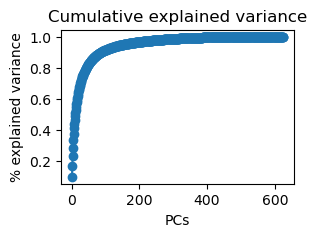

In [11]:
# Prepare flattened images
all_train_images_flat = all_train_images.squeeze().reshape(ALL_TRAIN_LEN, -1)
all_test_images_flat = all_test_images.squeeze().reshape(ALL_TEST_LEN, -1)

# Dimension settings
# DST_DIMS = [10, 35, 500]
DST_DIMS = range(10, 500, 20)
# DST_DIMS = [2, 4, 6, 8] + list(range(10, 50, 5)) + list(range(50, 100, 10)) + list(range(100, 200, 20)) + list(range(200,650, 25))

# Initialize dictionaries
dsts_train, dsts_test = dict.fromkeys(DST_DIMS), dict.fromkeys(DST_DIMS)

print("Creating low-dim MNIST datasets...", end="")
for n_pcs in DST_DIMS:
    print(n_pcs, end=",")
    # Fit PCA on train images
    pca = PCA(n_components=n_pcs)
    pca.fit(all_train_images_flat)

    # Apply to train set
    proj_X_train = pca.transform(all_train_images_flat)
    recnst_X_train = pca.inverse_transform(proj_X_train)

    trainset = TensorDataset(torch.Tensor(recnst_X_train), all_train_labels)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    dsts_train[n_pcs] = trainloader

    # plot_image_samples(recnst_X_train.reshape(len(train_dataset), 28, 28), 35, fig_title=f"reconstruction {n_pcs} PCs")

    # Apply to test set (fit is on train, as best practice)
    proj_X_test = pca.transform(all_test_images_flat)
    recnst_X_test = pca.inverse_transform(proj_X_test)

    testset = TensorDataset(torch.Tensor(recnst_X_test), all_test_labels)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    #Save the testloader and trainloader for MNIST
    dsts_test[n_pcs] = testloader
print("done")

plot_cum_variance_explained(pca, n_pcs)
plt.show()

## Define classifier for the reconstructed images

In [16]:
state_dict_deepali = torch.load("saved_models/best_cnn_mnist.pth", map_location=device)
# for k in state_dict_deepali:
#     print(k, state_dict_deepali[k].shape)

/tmp/ipykernel_1382722/603111270.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_deepali = torch.load("saved_models/best_cnn_mnist.pth", map_location=device)


In [18]:
class DeepaliCNN(nn.Module):
    def __init__(self):
        super(DeepaliCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


In [21]:
cnn_classifier = DeepaliCNN().to(device)
cnn_classifier.load_state_dict(state_dict_deepali)#torch.load("/content/best_cnn_mnist.pth", map_location=device))
cnn_classifier.eval();

In [26]:
def evaluate_pca_reconstructions(dsts_test, classifier, device):
    classifier.eval()
    pca_results = []

    for n_pcs, testloader in dsts_test.items():
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in testloader:
                x_batch = x_batch.view(-1, 1, 28, 28).to(device)  # Reshape & send to device
                y_batch = y_batch.to(device)
                outputs = classifier(x_batch)
                preds = outputs.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        accuracy = correct / total
        pca_results.append((n_pcs, accuracy))
        print(f"PCA-{n_pcs:>3} → Accuracy: {accuracy:.4f}")

    return pca_results

pca_eval_results = evaluate_pca_reconstructions(dsts_test, cnn_classifier, device)

PCA-  2 → Accuracy: 0.2418
PCA-  4 → Accuracy: 0.3075
PCA-  6 → Accuracy: 0.3987
PCA-  8 → Accuracy: 0.5054
PCA- 10 → Accuracy: 0.6072
PCA- 15 → Accuracy: 0.7504
PCA- 20 → Accuracy: 0.8498
PCA- 25 → Accuracy: 0.8932
PCA- 30 → Accuracy: 0.9175
PCA- 35 → Accuracy: 0.9323
PCA- 40 → Accuracy: 0.9409
PCA- 45 → Accuracy: 0.9543
PCA- 50 → Accuracy: 0.9629
PCA- 60 → Accuracy: 0.9739
PCA- 70 → Accuracy: 0.9821
PCA- 80 → Accuracy: 0.9863
PCA- 90 → Accuracy: 0.9878
PCA-100 → Accuracy: 0.9893
PCA-120 → Accuracy: 0.9919
PCA-140 → Accuracy: 0.9916
PCA-160 → Accuracy: 0.9923
PCA-180 → Accuracy: 0.9927
PCA-200 → Accuracy: 0.9923
PCA-225 → Accuracy: 0.9936
PCA-250 → Accuracy: 0.9938
PCA-275 → Accuracy: 0.9940
PCA-300 → Accuracy: 0.9941
PCA-325 → Accuracy: 0.9939
PCA-350 → Accuracy: 0.9938
PCA-375 → Accuracy: 0.9941
PCA-400 → Accuracy: 0.9940
PCA-425 → Accuracy: 0.9939
PCA-450 → Accuracy: 0.9938
PCA-475 → Accuracy: 0.9937
PCA-500 → Accuracy: 0.9936
PCA-525 → Accuracy: 0.9937
PCA-550 → Accuracy: 0.9938
P

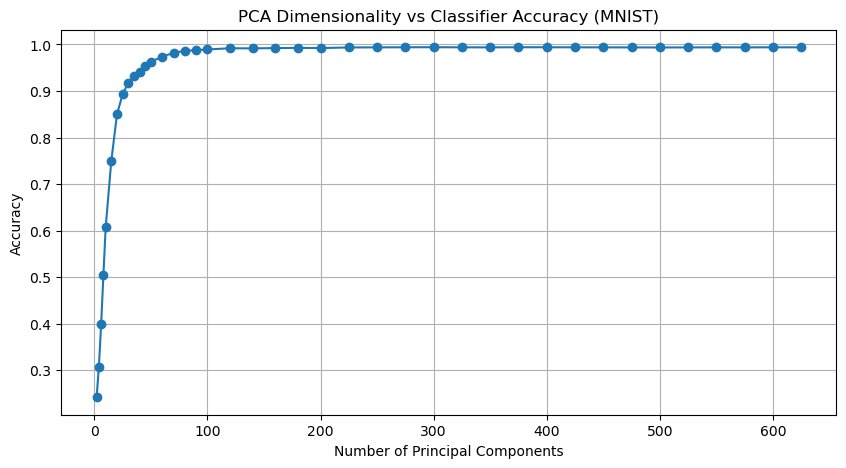

In [28]:
# Convert to DataFrame for plotting
# import pandas as pd
# import seaborn as sns
# df_pca = pd.DataFrame(pca_eval_results, columns=["n_pcs", "accuracy"])

plt.figure(figsize=(10, 5))
plt.plot(DST_DIMS, [acc for (_, acc) in pca_eval_results], '-o')
# sns.lineplot(data=df_pca, x="n_pcs", y="accuracy", marker="o")
plt.title("PCA Dimensionality vs Classifier Accuracy (MNIST)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Define, train and save VAEs

In [32]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[512, 256], latent_dim=50):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dims[1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[1], latent_dim)

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[1])

        self.decoder = nn.Sequential(
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z


In [33]:
# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [159]:
def train_vae(vae, optimizer, train_loader, test_loader, epochs):
    vae.train()
    total_loss = 0

    patience_counter = 0
    patience = 4
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in train_loader:
            x = x.view(-1, 784).to(device)
            recon, mu, logvar, _ = vae(x)
            loss = vae_loss(recon, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_epoch_loss)
        total_loss += epoch_loss

        # --- Evaluation ---
        vae.eval()
        test_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.view(-1, 784).to(device)
                recon, mu, logvar, _ = vae(x)
                loss = vae_loss(recon, x, mu, logvar)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        print(f"VAE Epoch {epoch+1}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {avg_test_loss:.4f}, patience_counter={patience_counter}, patience={patience}")

        # --- Save Best Model ---
        ndims = vae.decoder_input.in_features
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(vae, f"saved_models/mnist_best_vae_dim_{ndims}.pth")
            print(f"✅ Best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("🚦🚦🚦 Early stopping triggered 🚦")
                break
    
    # Plot training curve
    plt.figure()
    plt.title(f"Training curve - VAE latent dim={ndims}")
    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    return train_losses, test_losses

### ndim=2 ###
VAE Epoch 1/30, Train Loss: 172.9489, Test Loss: 158.6740, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 158.6740
VAE Epoch 2/30, Train Loss: 155.1405, Test Loss: 153.4683, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 153.4683
VAE Epoch 3/30, Train Loss: 151.2891, Test Loss: 149.6165, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 149.6165
VAE Epoch 4/30, Train Loss: 148.8332, Test Loss: 147.9503, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 147.9503
VAE Epoch 5/30, Train Loss: 147.1523, Test Loss: 146.5478, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 146.5478
VAE Epoch 6/30, Train Loss: 145.6020, Test Loss: 145.4657, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 145.4657
VAE Epoch 7/30, Train Loss: 144.6576, Test Loss: 144.6105, patience_counter=0, patience=4
✅ Best model saved at epo

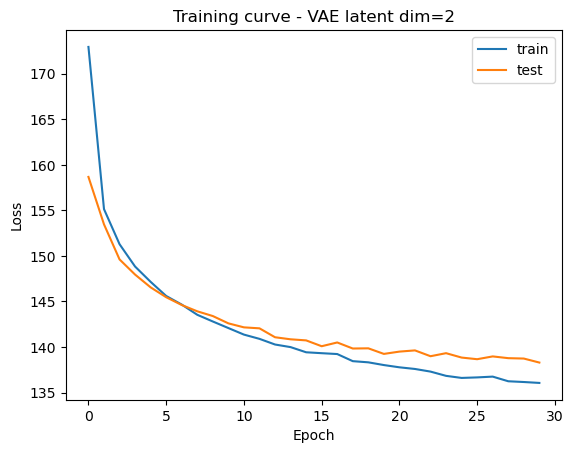

### ndim=4 ###
VAE Epoch 1/30, Train Loss: 155.1653, Test Loss: 136.3260, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 136.3260
VAE Epoch 2/30, Train Loss: 132.6034, Test Loss: 130.1532, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 130.1532
VAE Epoch 3/30, Train Loss: 128.6166, Test Loss: 127.9361, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 127.9361
VAE Epoch 4/30, Train Loss: 126.5244, Test Loss: 126.1532, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 126.1532
VAE Epoch 5/30, Train Loss: 125.0741, Test Loss: 125.4303, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 125.4303
VAE Epoch 6/30, Train Loss: 123.9662, Test Loss: 124.4260, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 124.4260
VAE Epoch 7/30, Train Loss: 123.1077, Test Loss: 123.6515, patience_counter=0, patience=4
✅ Best model saved at epo

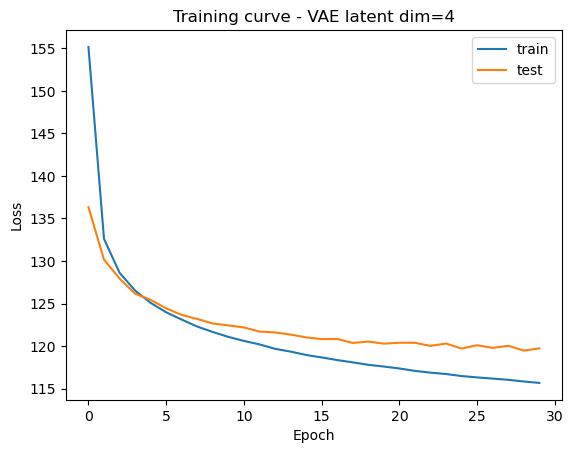

### ndim=6 ###
VAE Epoch 1/30, Train Loss: 145.1993, Test Loss: 124.9413, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 124.9413
VAE Epoch 2/30, Train Loss: 121.8522, Test Loss: 118.5847, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 118.5847
VAE Epoch 3/30, Train Loss: 117.8723, Test Loss: 116.3465, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 116.3465
VAE Epoch 4/30, Train Loss: 115.6437, Test Loss: 115.0269, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 115.0269
VAE Epoch 5/30, Train Loss: 114.1629, Test Loss: 113.5026, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 113.5026
VAE Epoch 6/30, Train Loss: 113.0471, Test Loss: 112.9503, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 112.9503
VAE Epoch 7/30, Train Loss: 112.1237, Test Loss: 112.5930, patience_counter=0, patience=4
✅ Best model saved at epo

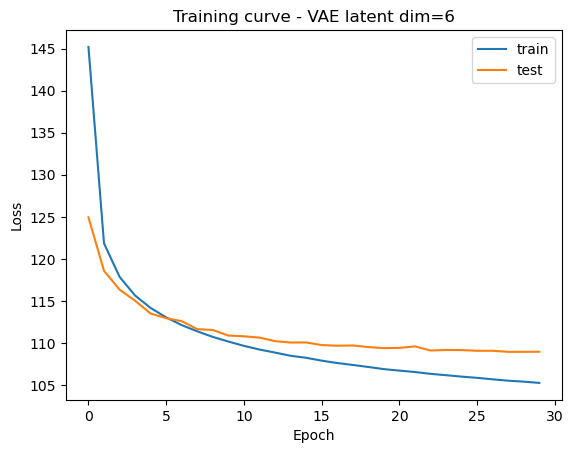

### ndim=8 ###
VAE Epoch 1/30, Train Loss: 141.3263, Test Loss: 119.4372, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 119.4372
VAE Epoch 2/30, Train Loss: 116.0812, Test Loss: 112.8777, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 112.8777
VAE Epoch 3/30, Train Loss: 111.8123, Test Loss: 110.1232, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 110.1232
VAE Epoch 4/30, Train Loss: 109.6296, Test Loss: 109.1099, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 109.1099
VAE Epoch 5/30, Train Loss: 108.1794, Test Loss: 108.2351, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 108.2351
VAE Epoch 6/30, Train Loss: 107.1759, Test Loss: 106.9274, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 106.9274
VAE Epoch 7/30, Train Loss: 106.2959, Test Loss: 106.2633, patience_counter=0, patience=4
✅ Best model saved at epo

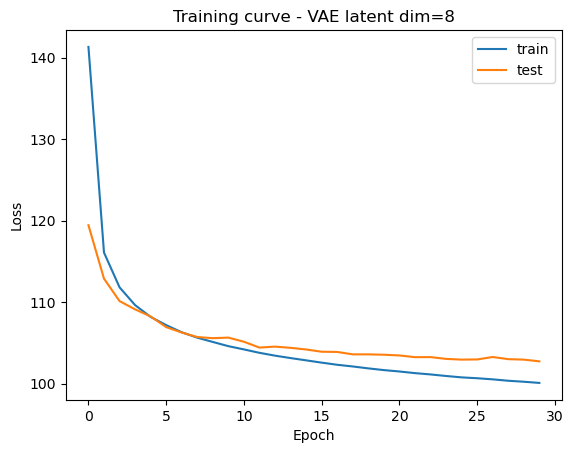

### ndim=10 ###
VAE Epoch 1/30, Train Loss: 139.6311, Test Loss: 116.3613, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 116.3613
VAE Epoch 2/30, Train Loss: 113.4363, Test Loss: 109.9776, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 109.9776
VAE Epoch 3/30, Train Loss: 109.0054, Test Loss: 107.2080, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 107.2080
VAE Epoch 4/30, Train Loss: 106.9220, Test Loss: 105.6971, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.6971
VAE Epoch 5/30, Train Loss: 105.4875, Test Loss: 104.6600, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.6600
VAE Epoch 6/30, Train Loss: 104.4855, Test Loss: 103.9551, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.9551
VAE Epoch 7/30, Train Loss: 103.6717, Test Loss: 103.6480, patience_counter=0, patience=4
✅ Best model saved at ep

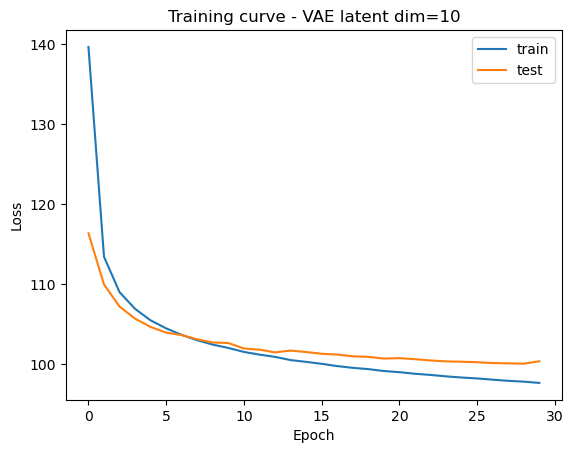

### ndim=15 ###
VAE Epoch 1/30, Train Loss: 138.6981, Test Loss: 114.3959, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 114.3959
VAE Epoch 2/30, Train Loss: 111.4555, Test Loss: 108.1320, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 108.1320
VAE Epoch 3/30, Train Loss: 107.3210, Test Loss: 106.3967, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.3967
VAE Epoch 4/30, Train Loss: 105.3136, Test Loss: 104.2885, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 104.2885
VAE Epoch 5/30, Train Loss: 104.0664, Test Loss: 103.6026, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 103.6026
VAE Epoch 6/30, Train Loss: 103.1677, Test Loss: 102.8426, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 102.8426
VAE Epoch 7/30, Train Loss: 102.3965, Test Loss: 102.5651, patience_counter=0, patience=4
✅ Best model saved at ep

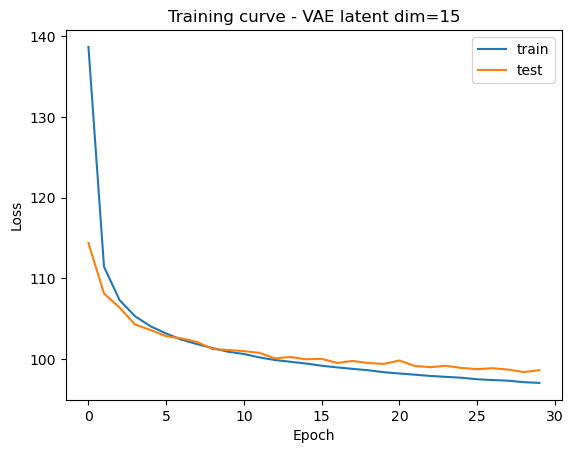

### ndim=20 ###
VAE Epoch 1/30, Train Loss: 140.3394, Test Loss: 115.0344, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 115.0344
VAE Epoch 2/30, Train Loss: 112.1311, Test Loss: 108.6122, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 108.6122
VAE Epoch 3/30, Train Loss: 107.7476, Test Loss: 106.5965, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.5965
VAE Epoch 4/30, Train Loss: 105.7834, Test Loss: 104.5395, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 104.5395
VAE Epoch 5/30, Train Loss: 104.4906, Test Loss: 104.2114, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.2114
VAE Epoch 6/30, Train Loss: 103.5048, Test Loss: 103.3498, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.3498
VAE Epoch 7/30, Train Loss: 102.7831, Test Loss: 102.6150, patience_counter=0, patience=4
✅ Best model saved at ep

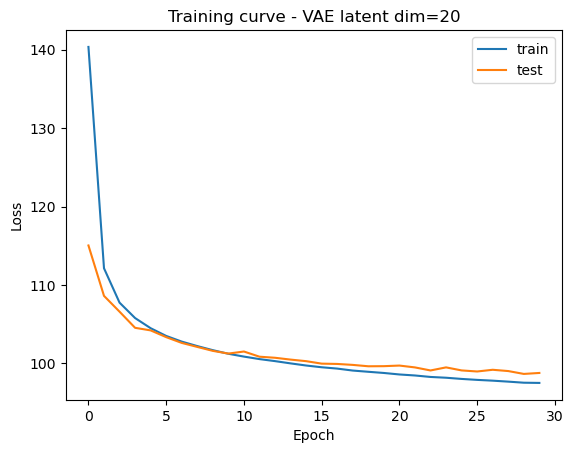

### ndim=25 ###
VAE Epoch 1/30, Train Loss: 142.1615, Test Loss: 116.1999, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 116.1999
VAE Epoch 2/30, Train Loss: 112.8968, Test Loss: 108.7741, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 108.7741
VAE Epoch 3/30, Train Loss: 108.0242, Test Loss: 106.1272, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.1272
VAE Epoch 4/30, Train Loss: 105.9134, Test Loss: 104.8650, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 104.8650
VAE Epoch 5/30, Train Loss: 104.5117, Test Loss: 104.0777, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.0777
VAE Epoch 6/30, Train Loss: 103.6434, Test Loss: 102.9439, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 102.9439
VAE Epoch 7/30, Train Loss: 102.8736, Test Loss: 102.8674, patience_counter=0, patience=4
✅ Best model saved at ep

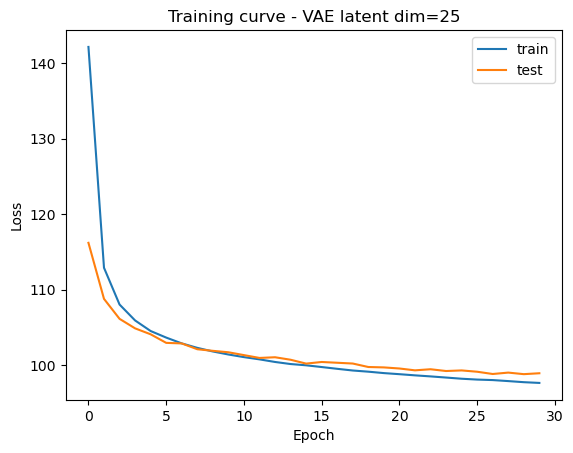

### ndim=30 ###
VAE Epoch 1/30, Train Loss: 143.5883, Test Loss: 117.3795, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 117.3795
VAE Epoch 2/30, Train Loss: 113.4486, Test Loss: 109.2385, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 109.2385
VAE Epoch 3/30, Train Loss: 108.4596, Test Loss: 106.8752, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.8752
VAE Epoch 4/30, Train Loss: 106.1989, Test Loss: 104.8220, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 104.8220
VAE Epoch 5/30, Train Loss: 104.8184, Test Loss: 104.3954, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.3954
VAE Epoch 6/30, Train Loss: 103.7185, Test Loss: 103.1008, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.1008
VAE Epoch 7/30, Train Loss: 102.9826, Test Loss: 102.9148, patience_counter=0, patience=4
✅ Best model saved at ep

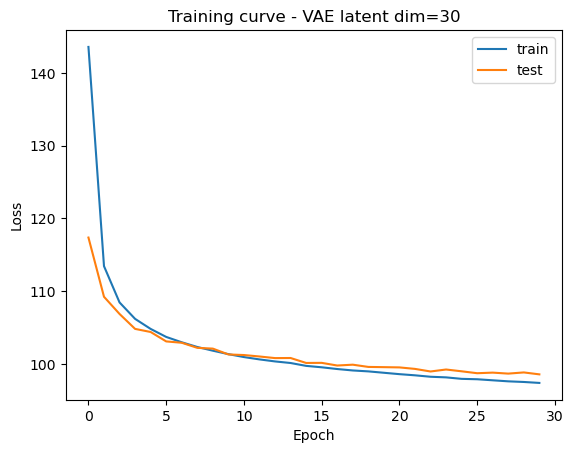

### ndim=35 ###
VAE Epoch 1/30, Train Loss: 145.7065, Test Loss: 118.8528, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 118.8528
VAE Epoch 2/30, Train Loss: 114.5395, Test Loss: 109.7722, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 109.7722
VAE Epoch 3/30, Train Loss: 108.6972, Test Loss: 106.4408, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.4408
VAE Epoch 4/30, Train Loss: 106.2424, Test Loss: 105.0940, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.0940
VAE Epoch 5/30, Train Loss: 104.8263, Test Loss: 104.0286, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.0286
VAE Epoch 6/30, Train Loss: 103.8631, Test Loss: 103.2380, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.2380
VAE Epoch 7/30, Train Loss: 103.0838, Test Loss: 102.7855, patience_counter=0, patience=4
✅ Best model saved at ep

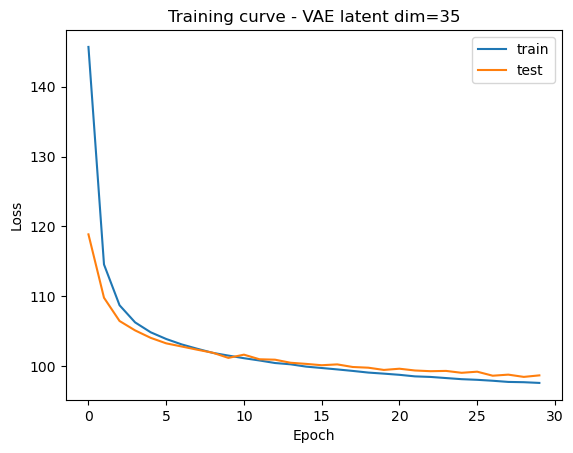

### ndim=40 ###
VAE Epoch 1/30, Train Loss: 145.8001, Test Loss: 118.3975, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 118.3975
VAE Epoch 2/30, Train Loss: 114.1540, Test Loss: 109.2475, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 109.2475
VAE Epoch 3/30, Train Loss: 108.6932, Test Loss: 106.4945, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.4945
VAE Epoch 4/30, Train Loss: 106.3251, Test Loss: 104.9890, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 104.9890
VAE Epoch 5/30, Train Loss: 104.8863, Test Loss: 103.8114, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 103.8114
VAE Epoch 6/30, Train Loss: 103.8249, Test Loss: 103.4408, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.4408
VAE Epoch 7/30, Train Loss: 103.0343, Test Loss: 102.5681, patience_counter=0, patience=4
✅ Best model saved at ep

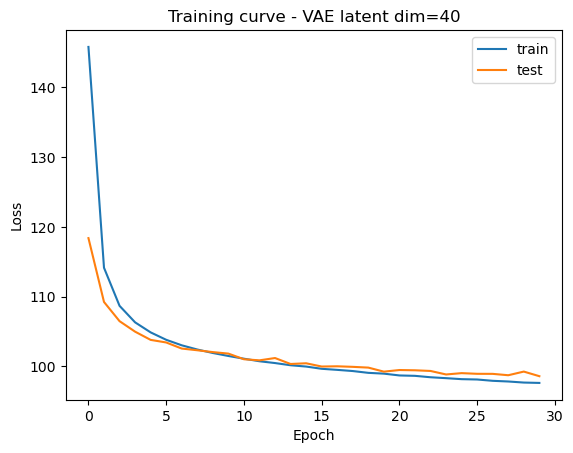

### ndim=45 ###
VAE Epoch 1/30, Train Loss: 147.3962, Test Loss: 119.8315, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 119.8315
VAE Epoch 2/30, Train Loss: 114.7422, Test Loss: 110.1229, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 110.1229
VAE Epoch 3/30, Train Loss: 108.8449, Test Loss: 106.3881, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 106.3881
VAE Epoch 4/30, Train Loss: 106.3114, Test Loss: 105.2881, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.2881
VAE Epoch 5/30, Train Loss: 104.8701, Test Loss: 103.7787, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 103.7787
VAE Epoch 6/30, Train Loss: 103.7755, Test Loss: 103.0982, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.0982
VAE Epoch 7/30, Train Loss: 102.9831, Test Loss: 102.8685, patience_counter=0, patience=4
✅ Best model saved at ep

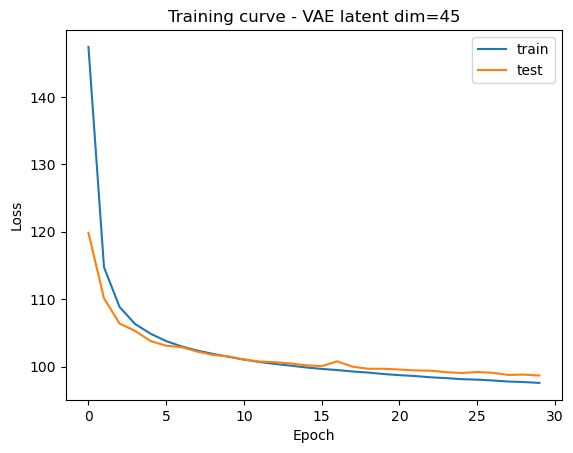

### ndim=50 ###
VAE Epoch 1/30, Train Loss: 148.6759, Test Loss: 121.3196, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 121.3196
VAE Epoch 2/30, Train Loss: 115.6496, Test Loss: 110.4563, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 110.4563
VAE Epoch 3/30, Train Loss: 109.1971, Test Loss: 107.5999, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 107.5999
VAE Epoch 4/30, Train Loss: 106.6466, Test Loss: 105.6467, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.6467
VAE Epoch 5/30, Train Loss: 105.1375, Test Loss: 104.4341, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.4341
VAE Epoch 6/30, Train Loss: 104.0352, Test Loss: 103.5235, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.5235
VAE Epoch 7/30, Train Loss: 103.3153, Test Loss: 102.9604, patience_counter=0, patience=4
✅ Best model saved at ep

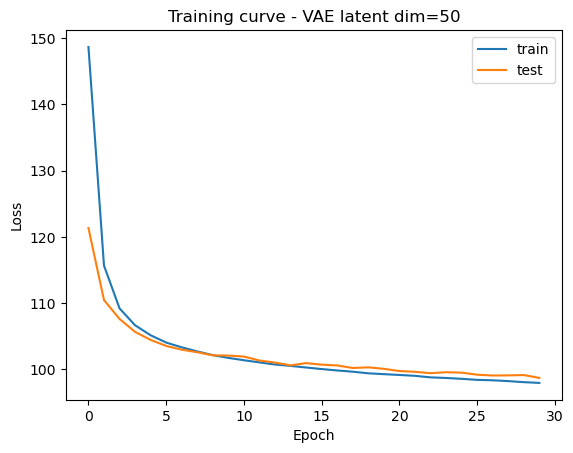

### ndim=60 ###
VAE Epoch 1/30, Train Loss: 150.2541, Test Loss: 122.3786, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 122.3786
VAE Epoch 2/30, Train Loss: 115.8812, Test Loss: 110.7603, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 110.7603
VAE Epoch 3/30, Train Loss: 109.4324, Test Loss: 107.2615, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 107.2615
VAE Epoch 4/30, Train Loss: 106.7339, Test Loss: 105.2877, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.2877
VAE Epoch 5/30, Train Loss: 105.1063, Test Loss: 104.2740, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.2740
VAE Epoch 6/30, Train Loss: 104.0609, Test Loss: 103.5777, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.5777
VAE Epoch 7/30, Train Loss: 103.2403, Test Loss: 102.7811, patience_counter=0, patience=4
✅ Best model saved at ep

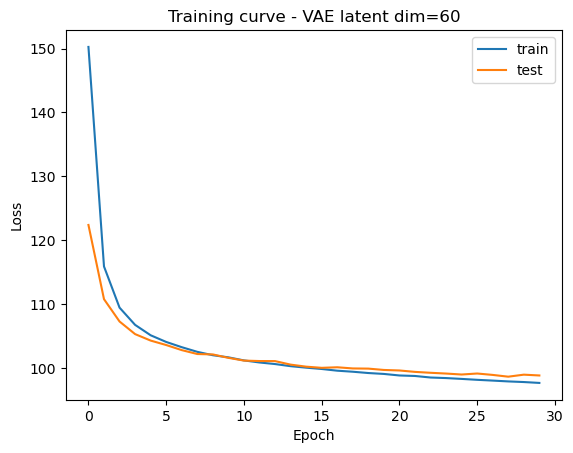

### ndim=70 ###
VAE Epoch 1/30, Train Loss: 151.4914, Test Loss: 122.7750, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 122.7750
VAE Epoch 2/30, Train Loss: 116.7848, Test Loss: 111.4599, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 111.4599
VAE Epoch 3/30, Train Loss: 109.8756, Test Loss: 107.7462, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 107.7462
VAE Epoch 4/30, Train Loss: 106.8696, Test Loss: 105.5463, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.5463
VAE Epoch 5/30, Train Loss: 105.0678, Test Loss: 105.1019, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.1019
VAE Epoch 6/30, Train Loss: 103.9042, Test Loss: 103.1724, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.1724
VAE Epoch 7/30, Train Loss: 103.0378, Test Loss: 102.3447, patience_counter=0, patience=4
✅ Best model saved at ep

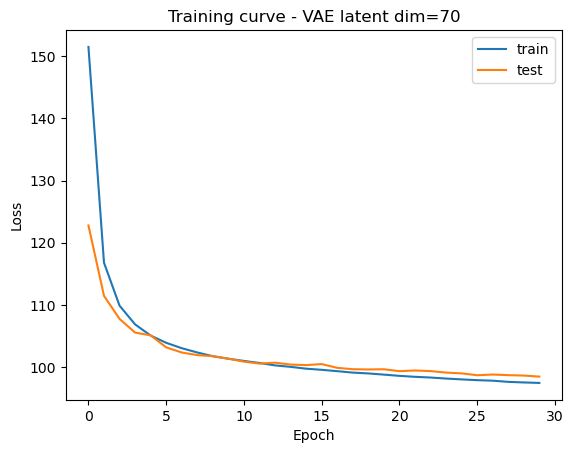

### ndim=80 ###
VAE Epoch 1/30, Train Loss: 152.3250, Test Loss: 123.6000, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 123.6000
VAE Epoch 2/30, Train Loss: 117.2532, Test Loss: 111.5435, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 111.5435
VAE Epoch 3/30, Train Loss: 110.2150, Test Loss: 107.4761, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 107.4761
VAE Epoch 4/30, Train Loss: 107.1053, Test Loss: 105.6405, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.6405
VAE Epoch 5/30, Train Loss: 105.2673, Test Loss: 104.7046, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.7046
VAE Epoch 6/30, Train Loss: 104.1230, Test Loss: 103.2567, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.2567
VAE Epoch 7/30, Train Loss: 103.2296, Test Loss: 102.8716, patience_counter=0, patience=4
✅ Best model saved at ep

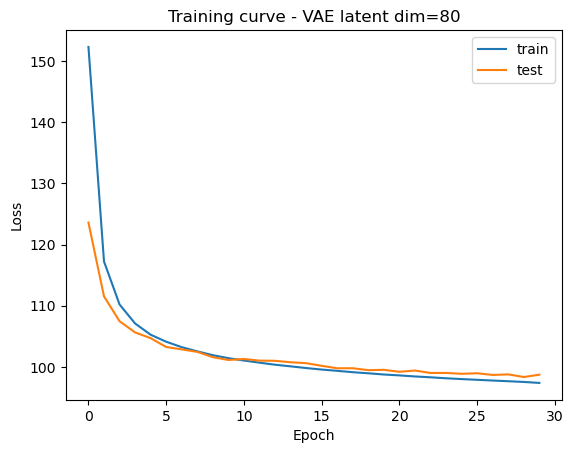

### ndim=90 ###
VAE Epoch 1/30, Train Loss: 154.8450, Test Loss: 127.8365, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 127.8365
VAE Epoch 2/30, Train Loss: 119.3157, Test Loss: 112.2382, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 112.2382
VAE Epoch 3/30, Train Loss: 110.9032, Test Loss: 108.4352, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 108.4352
VAE Epoch 4/30, Train Loss: 107.6216, Test Loss: 106.3673, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 106.3673
VAE Epoch 5/30, Train Loss: 105.7385, Test Loss: 104.7586, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.7586
VAE Epoch 6/30, Train Loss: 104.5106, Test Loss: 103.4756, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.4756
VAE Epoch 7/30, Train Loss: 103.5460, Test Loss: 103.0331, patience_counter=0, patience=4
✅ Best model saved at ep

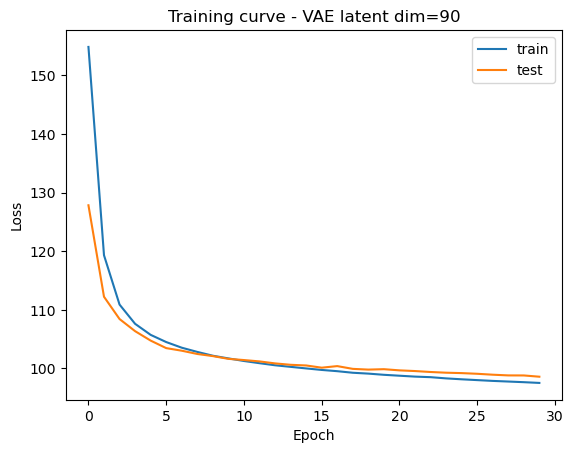

### ndim=100 ###
VAE Epoch 1/30, Train Loss: 155.0828, Test Loss: 127.0228, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 127.0228
VAE Epoch 2/30, Train Loss: 119.3303, Test Loss: 113.1821, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 113.1821
VAE Epoch 3/30, Train Loss: 111.0700, Test Loss: 108.5693, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 108.5693
VAE Epoch 4/30, Train Loss: 107.5647, Test Loss: 105.5508, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 105.5508
VAE Epoch 5/30, Train Loss: 105.6564, Test Loss: 104.3934, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.3934
VAE Epoch 6/30, Train Loss: 104.2575, Test Loss: 103.6262, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.6262
VAE Epoch 7/30, Train Loss: 103.2822, Test Loss: 102.8554, patience_counter=0, patience=4
✅ Best model saved at e

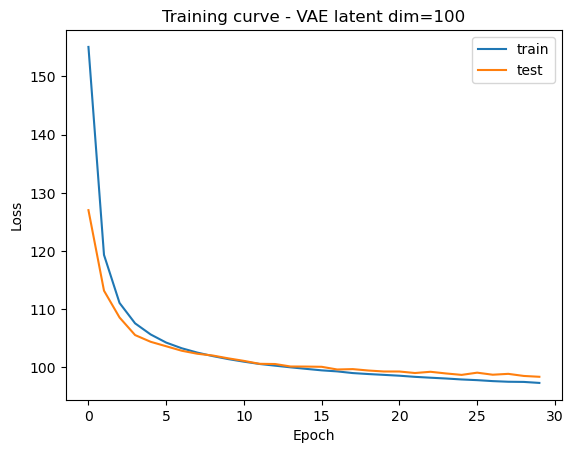

### ndim=120 ###
VAE Epoch 1/30, Train Loss: 156.6402, Test Loss: 128.4596, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 128.4596
VAE Epoch 2/30, Train Loss: 120.2744, Test Loss: 113.1772, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 113.1772
VAE Epoch 3/30, Train Loss: 111.3393, Test Loss: 108.4414, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 108.4414
VAE Epoch 4/30, Train Loss: 108.0075, Test Loss: 106.3788, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 106.3788
VAE Epoch 5/30, Train Loss: 106.0294, Test Loss: 104.8818, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 104.8818
VAE Epoch 6/30, Train Loss: 104.5494, Test Loss: 103.8484, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 103.8484
VAE Epoch 7/30, Train Loss: 103.4759, Test Loss: 103.2805, patience_counter=0, patience=4
✅ Best model saved at e

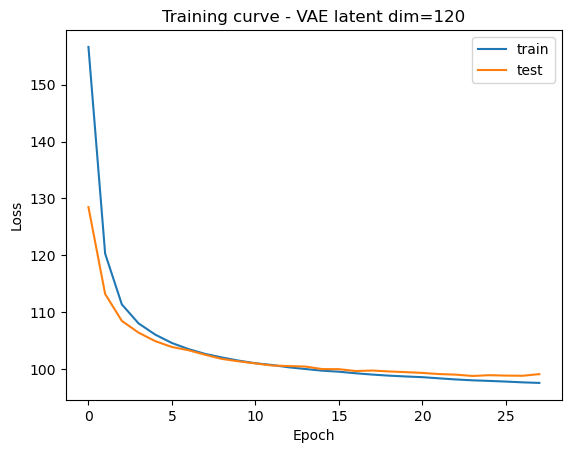

### ndim=140 ###
VAE Epoch 1/30, Train Loss: 158.5470, Test Loss: 132.2888, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 132.2888
VAE Epoch 2/30, Train Loss: 122.8370, Test Loss: 114.4629, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 114.4629
VAE Epoch 3/30, Train Loss: 112.3499, Test Loss: 108.9762, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 108.9762
VAE Epoch 4/30, Train Loss: 108.3422, Test Loss: 106.4205, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 106.4205
VAE Epoch 5/30, Train Loss: 106.2365, Test Loss: 105.0027, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.0027
VAE Epoch 6/30, Train Loss: 104.8706, Test Loss: 104.0728, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 104.0728
VAE Epoch 7/30, Train Loss: 103.9239, Test Loss: 103.3441, patience_counter=0, patience=4
✅ Best model saved at e

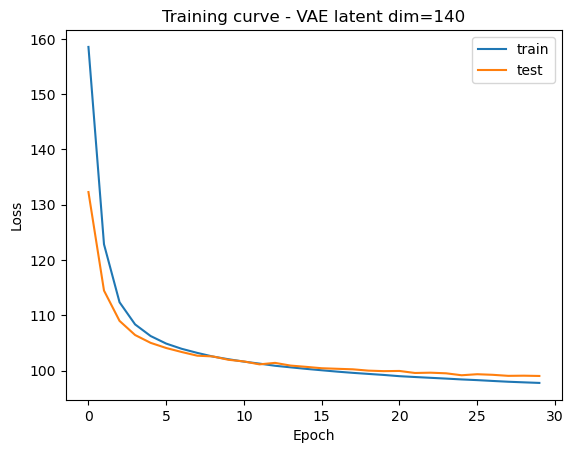

### ndim=160 ###
VAE Epoch 1/30, Train Loss: 159.7162, Test Loss: 134.1474, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 134.1474
VAE Epoch 2/30, Train Loss: 125.6198, Test Loss: 116.7870, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 116.7870
VAE Epoch 3/30, Train Loss: 113.8837, Test Loss: 109.9735, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 109.9735
VAE Epoch 4/30, Train Loss: 109.0991, Test Loss: 107.0025, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 107.0025
VAE Epoch 5/30, Train Loss: 106.8405, Test Loss: 105.3917, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.3917
VAE Epoch 6/30, Train Loss: 105.3479, Test Loss: 104.2801, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 104.2801
VAE Epoch 7/30, Train Loss: 104.2662, Test Loss: 103.5949, patience_counter=0, patience=4
✅ Best model saved at e

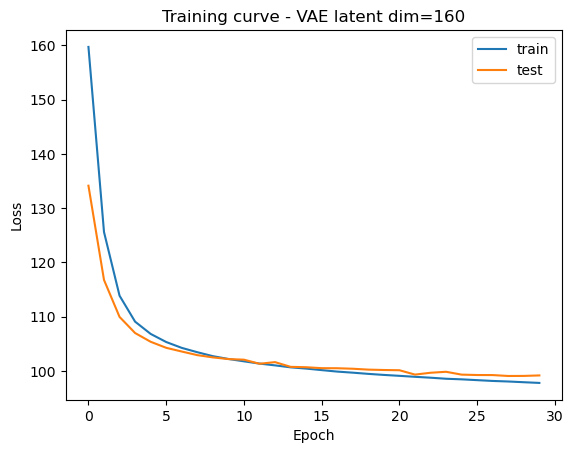

### ndim=180 ###
VAE Epoch 1/30, Train Loss: 160.5516, Test Loss: 134.9534, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 134.9534
VAE Epoch 2/30, Train Loss: 125.9602, Test Loss: 117.0267, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 117.0267
VAE Epoch 3/30, Train Loss: 113.8381, Test Loss: 109.7853, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 109.7853
VAE Epoch 4/30, Train Loss: 109.2754, Test Loss: 107.1875, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 107.1875
VAE Epoch 5/30, Train Loss: 106.8658, Test Loss: 105.8167, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.8167
VAE Epoch 6/30, Train Loss: 105.3008, Test Loss: 104.4825, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 104.4825
VAE Epoch 7/30, Train Loss: 104.1611, Test Loss: 103.8159, patience_counter=0, patience=4
✅ Best model saved at e

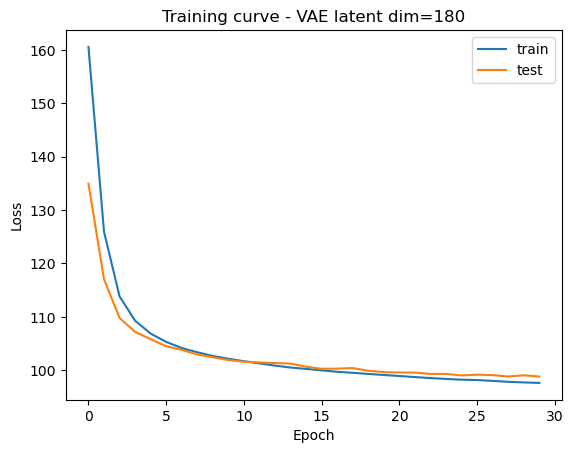

### ndim=200 ###
VAE Epoch 1/30, Train Loss: 161.4333, Test Loss: 136.2463, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 136.2463
VAE Epoch 2/30, Train Loss: 127.4532, Test Loss: 118.2062, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 118.2062
VAE Epoch 3/30, Train Loss: 114.9364, Test Loss: 110.5551, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 110.5551
VAE Epoch 4/30, Train Loss: 109.5928, Test Loss: 107.4804, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 107.4804
VAE Epoch 5/30, Train Loss: 107.0446, Test Loss: 105.6626, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.6626
VAE Epoch 6/30, Train Loss: 105.5125, Test Loss: 104.6054, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 104.6054
VAE Epoch 7/30, Train Loss: 104.3376, Test Loss: 103.9351, patience_counter=0, patience=4
✅ Best model saved at e

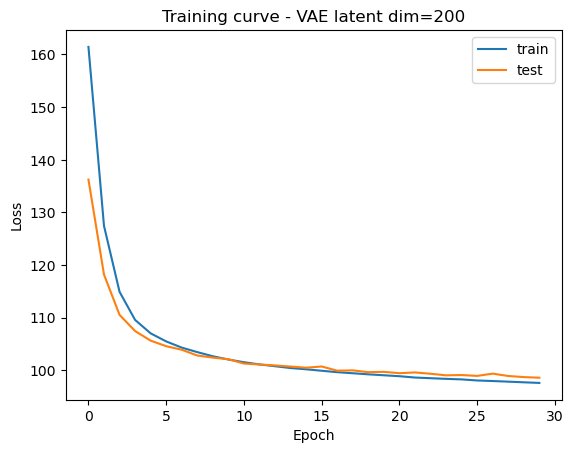

### ndim=225 ###
VAE Epoch 1/30, Train Loss: 162.4503, Test Loss: 139.4645, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 139.4645
VAE Epoch 2/30, Train Loss: 129.8010, Test Loss: 120.5881, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 120.5881
VAE Epoch 3/30, Train Loss: 116.7641, Test Loss: 112.2053, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 112.2053
VAE Epoch 4/30, Train Loss: 110.5765, Test Loss: 108.3941, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 108.3941
VAE Epoch 5/30, Train Loss: 107.6722, Test Loss: 105.8222, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 105.8222
VAE Epoch 6/30, Train Loss: 105.8885, Test Loss: 104.8528, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 104.8528
VAE Epoch 7/30, Train Loss: 104.7958, Test Loss: 104.2241, patience_counter=0, patience=4
✅ Best model saved at e

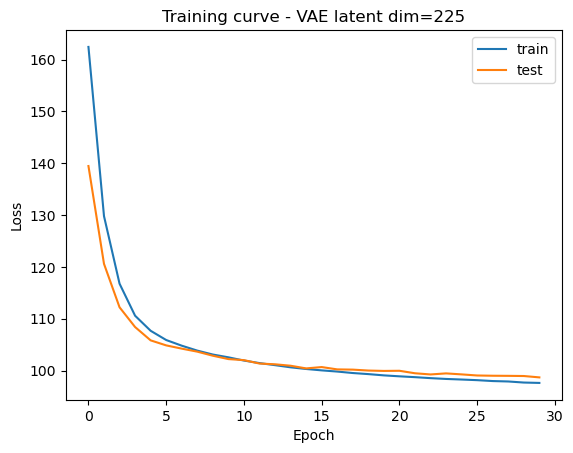

### ndim=250 ###
VAE Epoch 1/30, Train Loss: 163.2467, Test Loss: 140.3949, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 140.3949
VAE Epoch 2/30, Train Loss: 132.9992, Test Loss: 124.2416, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 124.2416
VAE Epoch 3/30, Train Loss: 119.0724, Test Loss: 113.6953, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 113.6953
VAE Epoch 4/30, Train Loss: 111.9840, Test Loss: 109.3578, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 109.3578
VAE Epoch 5/30, Train Loss: 108.4916, Test Loss: 106.9397, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 106.9397
VAE Epoch 6/30, Train Loss: 106.3946, Test Loss: 105.5639, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 105.5639
VAE Epoch 7/30, Train Loss: 104.9788, Test Loss: 104.4929, patience_counter=0, patience=4
✅ Best model saved at e

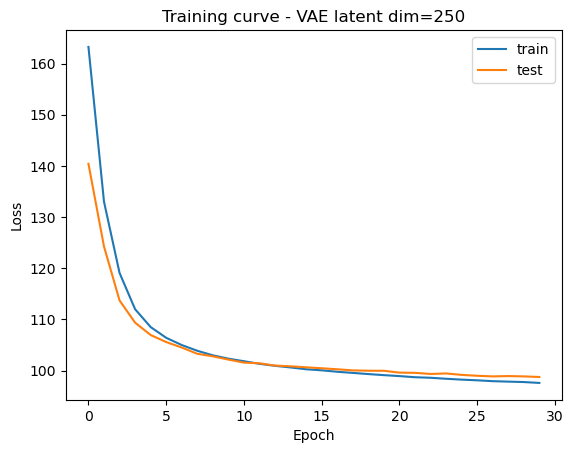

### ndim=275 ###
VAE Epoch 1/30, Train Loss: 164.4272, Test Loss: 141.3068, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 141.3068
VAE Epoch 2/30, Train Loss: 133.7195, Test Loss: 124.7775, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 124.7775
VAE Epoch 3/30, Train Loss: 119.2045, Test Loss: 113.8450, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 113.8450
VAE Epoch 4/30, Train Loss: 112.0962, Test Loss: 109.5952, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 109.5952
VAE Epoch 5/30, Train Loss: 108.6117, Test Loss: 106.5843, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 106.5843
VAE Epoch 6/30, Train Loss: 106.4969, Test Loss: 105.5887, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 105.5887
VAE Epoch 7/30, Train Loss: 105.2124, Test Loss: 104.2692, patience_counter=0, patience=4
✅ Best model saved at e

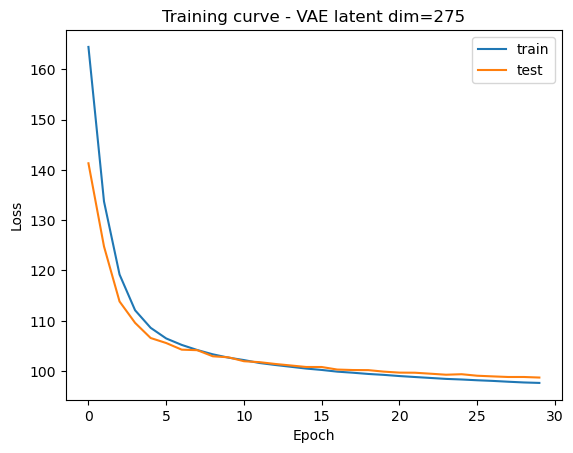

### ndim=300 ###
VAE Epoch 1/30, Train Loss: 164.9922, Test Loss: 142.0996, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 142.0996
VAE Epoch 2/30, Train Loss: 136.4040, Test Loss: 128.6095, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 128.6095
VAE Epoch 3/30, Train Loss: 123.0774, Test Loss: 116.4989, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 116.4989
VAE Epoch 4/30, Train Loss: 113.5363, Test Loss: 110.2554, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 110.2554
VAE Epoch 5/30, Train Loss: 109.3362, Test Loss: 107.6288, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 107.6288
VAE Epoch 6/30, Train Loss: 106.8654, Test Loss: 105.7292, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 105.7292
VAE Epoch 7/30, Train Loss: 105.3508, Test Loss: 104.6846, patience_counter=0, patience=4
✅ Best model saved at e

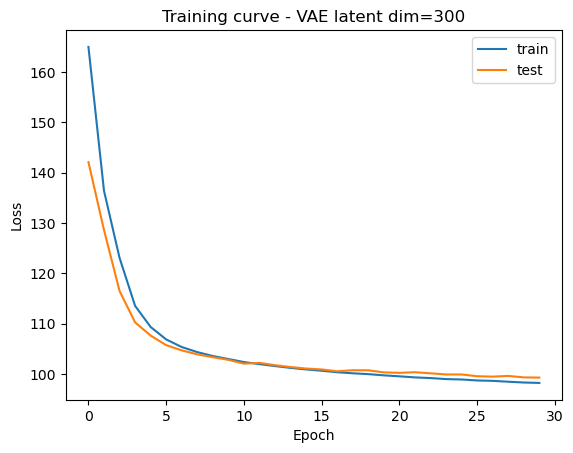

### ndim=325 ###
VAE Epoch 1/30, Train Loss: 165.2550, Test Loss: 142.9359, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 142.9359
VAE Epoch 2/30, Train Loss: 136.8083, Test Loss: 129.1391, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 129.1391
VAE Epoch 3/30, Train Loss: 124.1329, Test Loss: 118.0291, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 118.0291
VAE Epoch 4/30, Train Loss: 114.2285, Test Loss: 110.3089, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 110.3089
VAE Epoch 5/30, Train Loss: 109.5506, Test Loss: 107.9035, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 107.9035
VAE Epoch 6/30, Train Loss: 107.3031, Test Loss: 105.9700, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 105.9700
VAE Epoch 7/30, Train Loss: 105.7056, Test Loss: 104.6732, patience_counter=0, patience=4
✅ Best model saved at e

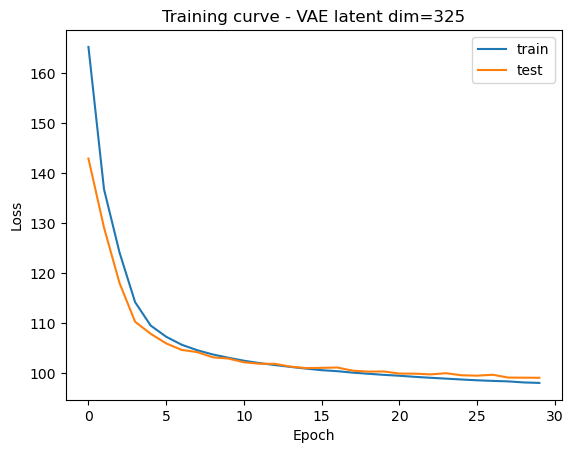

### ndim=350 ###
VAE Epoch 1/30, Train Loss: 165.9008, Test Loss: 144.0069, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 144.0069
VAE Epoch 2/30, Train Loss: 139.8396, Test Loss: 132.6705, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 132.6705
VAE Epoch 3/30, Train Loss: 127.0887, Test Loss: 120.3752, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 120.3752
VAE Epoch 4/30, Train Loss: 117.6922, Test Loss: 114.2508, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 114.2508
VAE Epoch 5/30, Train Loss: 112.8965, Test Loss: 110.7384, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 110.7384
VAE Epoch 6/30, Train Loss: 109.5613, Test Loss: 108.2443, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 108.2443
VAE Epoch 7/30, Train Loss: 107.1976, Test Loss: 106.0645, patience_counter=0, patience=4
✅ Best model saved at e

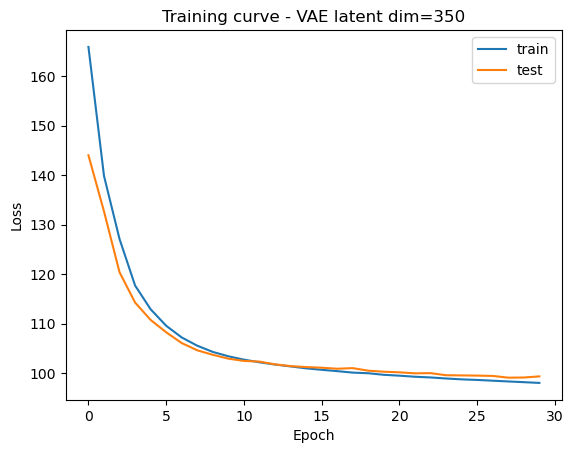

### ndim=375 ###
VAE Epoch 1/30, Train Loss: 166.1591, Test Loss: 144.5798, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 144.5798
VAE Epoch 2/30, Train Loss: 140.6149, Test Loss: 134.7793, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 134.7793
VAE Epoch 3/30, Train Loss: 131.0357, Test Loss: 125.6475, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 125.6475
VAE Epoch 4/30, Train Loss: 121.4593, Test Loss: 115.9449, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 115.9449
VAE Epoch 5/30, Train Loss: 113.8786, Test Loss: 110.6799, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 110.6799
VAE Epoch 6/30, Train Loss: 109.5465, Test Loss: 107.7630, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 107.7630
VAE Epoch 7/30, Train Loss: 107.0578, Test Loss: 105.9098, patience_counter=0, patience=4
✅ Best model saved at e

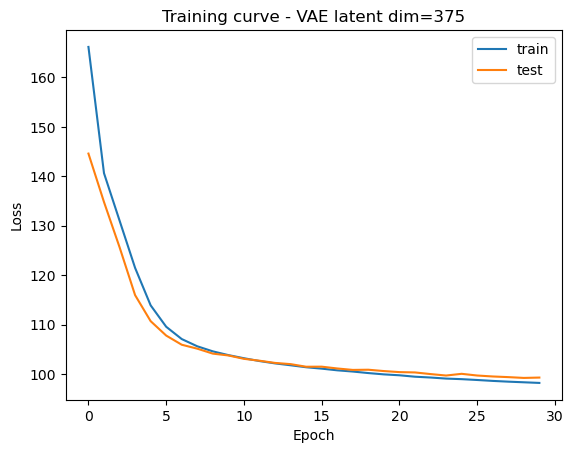

### ndim=400 ###
VAE Epoch 1/30, Train Loss: 166.9309, Test Loss: 144.5548, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 144.5548
VAE Epoch 2/30, Train Loss: 139.9798, Test Loss: 133.0250, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 133.0250
VAE Epoch 3/30, Train Loss: 128.0339, Test Loss: 121.5034, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 121.5034
VAE Epoch 4/30, Train Loss: 118.6253, Test Loss: 114.5699, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 114.5699
VAE Epoch 5/30, Train Loss: 112.4837, Test Loss: 109.4849, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 109.4849
VAE Epoch 6/30, Train Loss: 108.9330, Test Loss: 107.7111, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 107.7111
VAE Epoch 7/30, Train Loss: 106.8906, Test Loss: 105.6325, patience_counter=0, patience=4
✅ Best model saved at e

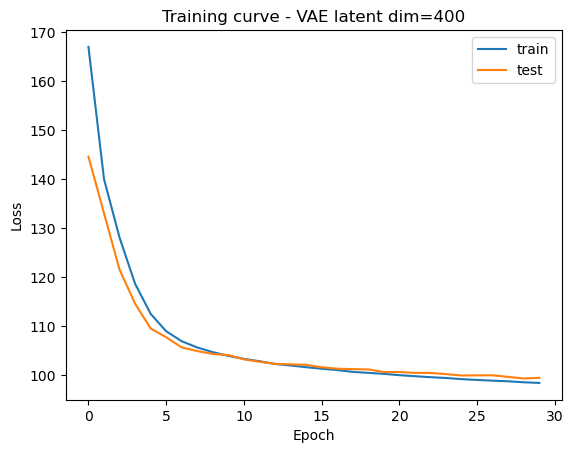

### ndim=425 ###
VAE Epoch 1/30, Train Loss: 166.6442, Test Loss: 144.9633, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 144.9633
VAE Epoch 2/30, Train Loss: 141.5636, Test Loss: 137.3983, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 137.3983
VAE Epoch 3/30, Train Loss: 134.5161, Test Loss: 128.5701, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 128.5701
VAE Epoch 4/30, Train Loss: 123.6269, Test Loss: 118.3354, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 118.3354
VAE Epoch 5/30, Train Loss: 115.5765, Test Loss: 112.4776, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 112.4776
VAE Epoch 6/30, Train Loss: 111.2136, Test Loss: 109.3121, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 109.3121
VAE Epoch 7/30, Train Loss: 108.6242, Test Loss: 107.2349, patience_counter=0, patience=4
✅ Best model saved at e

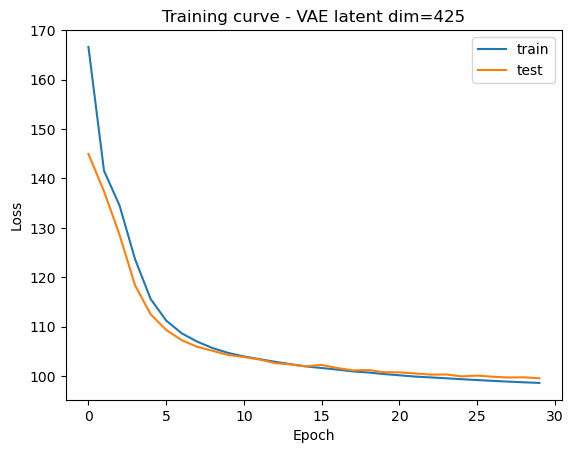

### ndim=450 ###
VAE Epoch 1/30, Train Loss: 167.5284, Test Loss: 145.4171, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 145.4171
VAE Epoch 2/30, Train Loss: 141.4940, Test Loss: 136.3953, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 136.3953
VAE Epoch 3/30, Train Loss: 132.7441, Test Loss: 126.9591, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 126.9591
VAE Epoch 4/30, Train Loss: 123.5548, Test Loss: 118.5621, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 118.5621
VAE Epoch 5/30, Train Loss: 116.3893, Test Loss: 112.9769, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 112.9769
VAE Epoch 6/30, Train Loss: 111.5407, Test Loss: 109.5488, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 109.5488
VAE Epoch 7/30, Train Loss: 108.7358, Test Loss: 107.3912, patience_counter=0, patience=4
✅ Best model saved at e

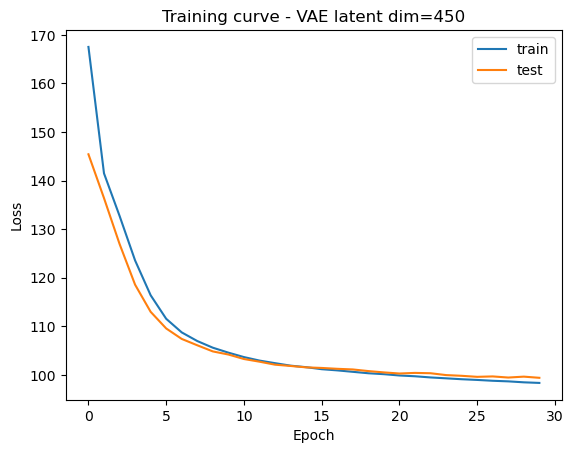

### ndim=475 ###
VAE Epoch 1/30, Train Loss: 167.1134, Test Loss: 144.5733, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 144.5733
VAE Epoch 2/30, Train Loss: 139.4913, Test Loss: 133.2202, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 133.2202
VAE Epoch 3/30, Train Loss: 129.9994, Test Loss: 125.1652, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 125.1652
VAE Epoch 4/30, Train Loss: 121.7351, Test Loss: 117.1077, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 117.1077
VAE Epoch 5/30, Train Loss: 114.9812, Test Loss: 112.2608, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 112.2608
VAE Epoch 6/30, Train Loss: 110.8217, Test Loss: 109.1306, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 109.1306
VAE Epoch 7/30, Train Loss: 108.4443, Test Loss: 107.0286, patience_counter=0, patience=4
✅ Best model saved at e

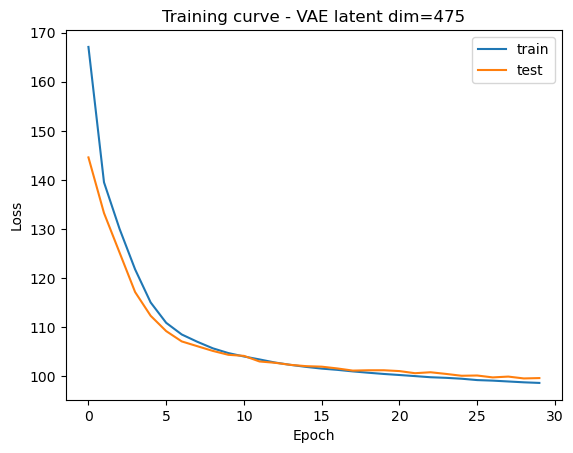

### ndim=500 ###
VAE Epoch 1/30, Train Loss: 167.9275, Test Loss: 146.0267, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 146.0267
VAE Epoch 2/30, Train Loss: 142.5440, Test Loss: 138.2052, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 138.2052
VAE Epoch 3/30, Train Loss: 136.7252, Test Loss: 133.2376, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 133.2376
VAE Epoch 4/30, Train Loss: 130.1604, Test Loss: 124.8022, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 124.8022
VAE Epoch 5/30, Train Loss: 121.3230, Test Loss: 116.6728, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 116.6728
VAE Epoch 6/30, Train Loss: 114.6445, Test Loss: 111.8843, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 111.8843
VAE Epoch 7/30, Train Loss: 110.5525, Test Loss: 108.7894, patience_counter=0, patience=4
✅ Best model saved at e

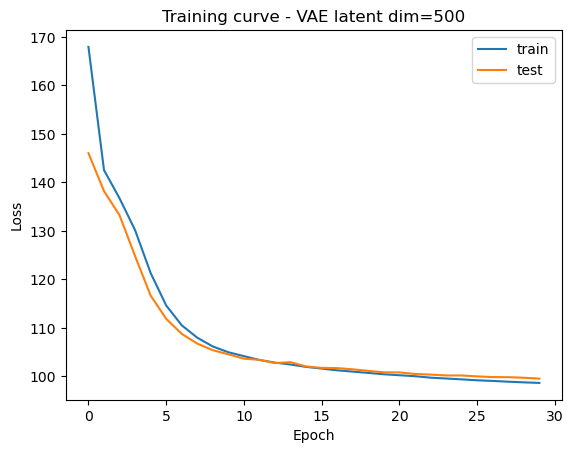

### ndim=525 ###
VAE Epoch 1/30, Train Loss: 168.7483, Test Loss: 145.9481, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 145.9481
VAE Epoch 2/30, Train Loss: 143.0104, Test Loss: 138.4340, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 138.4340
VAE Epoch 3/30, Train Loss: 137.3965, Test Loss: 134.2572, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 134.2572
VAE Epoch 4/30, Train Loss: 131.8897, Test Loss: 128.0210, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 128.0210
VAE Epoch 5/30, Train Loss: 123.7548, Test Loss: 118.9112, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 118.9112
VAE Epoch 6/30, Train Loss: 115.6850, Test Loss: 112.3559, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 112.3559
VAE Epoch 7/30, Train Loss: 111.4032, Test Loss: 109.6262, patience_counter=0, patience=4
✅ Best model saved at e

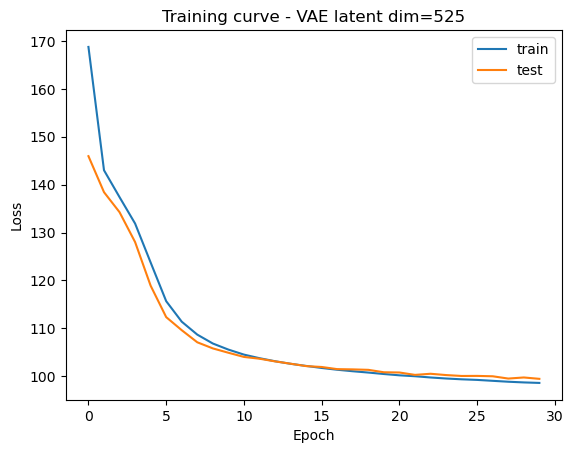

### ndim=550 ###
VAE Epoch 1/30, Train Loss: 168.7088, Test Loss: 147.1088, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 147.1088
VAE Epoch 2/30, Train Loss: 143.1420, Test Loss: 138.8282, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 138.8282
VAE Epoch 3/30, Train Loss: 137.7038, Test Loss: 135.3155, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 135.3155
VAE Epoch 4/30, Train Loss: 133.6300, Test Loss: 130.1638, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 130.1638
VAE Epoch 5/30, Train Loss: 127.8945, Test Loss: 124.2847, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 124.2847
VAE Epoch 6/30, Train Loss: 122.4207, Test Loss: 119.3675, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 119.3675
VAE Epoch 7/30, Train Loss: 117.2230, Test Loss: 114.4414, patience_counter=0, patience=4
✅ Best model saved at e

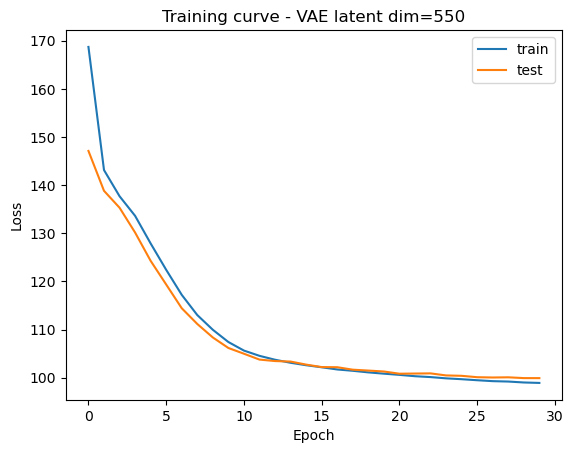

### ndim=575 ###
VAE Epoch 1/30, Train Loss: 168.0628, Test Loss: 146.6464, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 146.6464
VAE Epoch 2/30, Train Loss: 142.4469, Test Loss: 137.6443, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 137.6443
VAE Epoch 3/30, Train Loss: 135.6349, Test Loss: 132.8001, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 132.8001
VAE Epoch 4/30, Train Loss: 131.7450, Test Loss: 128.9526, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 128.9526
VAE Epoch 5/30, Train Loss: 126.6111, Test Loss: 122.2686, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 122.2686
VAE Epoch 6/30, Train Loss: 120.2065, Test Loss: 116.4916, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 116.4916
VAE Epoch 7/30, Train Loss: 115.0218, Test Loss: 112.6618, patience_counter=0, patience=4
✅ Best model saved at e

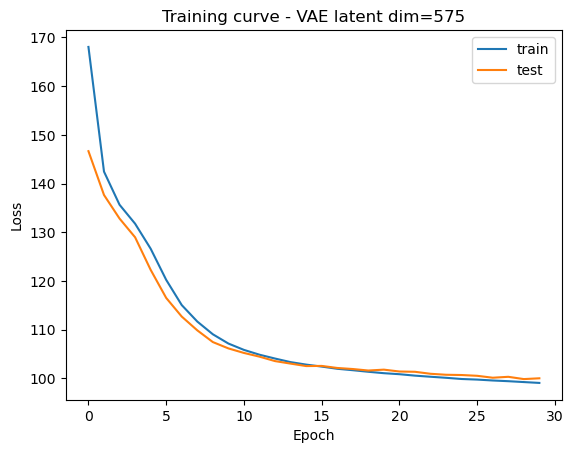

### ndim=600 ###
VAE Epoch 1/30, Train Loss: 169.7122, Test Loss: 146.9144, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 146.9144
VAE Epoch 2/30, Train Loss: 143.5159, Test Loss: 140.1451, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 140.1451
VAE Epoch 3/30, Train Loss: 138.0369, Test Loss: 136.0435, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 136.0435
VAE Epoch 4/30, Train Loss: 133.3170, Test Loss: 129.9676, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 129.9676
VAE Epoch 5/30, Train Loss: 127.5014, Test Loss: 123.6942, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 123.6942
VAE Epoch 6/30, Train Loss: 121.1853, Test Loss: 116.6842, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 116.6842
VAE Epoch 7/30, Train Loss: 115.2322, Test Loss: 112.5145, patience_counter=0, patience=4
✅ Best model saved at e

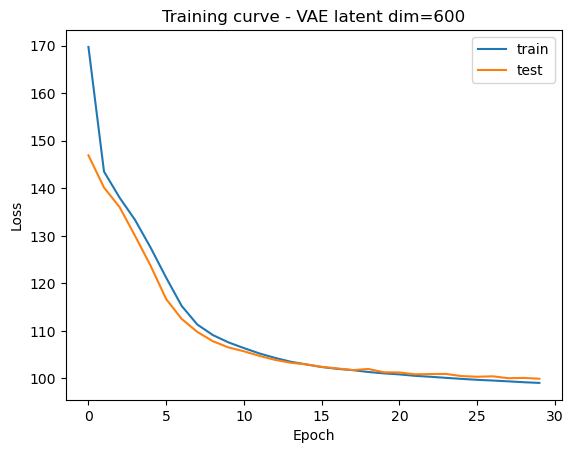

### ndim=625 ###
VAE Epoch 1/30, Train Loss: 170.6300, Test Loss: 147.3566, patience_counter=0, patience=4
✅ Best model saved at epoch 1 with test loss: 147.3566
VAE Epoch 2/30, Train Loss: 143.6781, Test Loss: 139.2676, patience_counter=0, patience=4
✅ Best model saved at epoch 2 with test loss: 139.2676
VAE Epoch 3/30, Train Loss: 138.3288, Test Loss: 136.3225, patience_counter=0, patience=4
✅ Best model saved at epoch 3 with test loss: 136.3225
VAE Epoch 4/30, Train Loss: 134.2671, Test Loss: 131.7051, patience_counter=0, patience=4
✅ Best model saved at epoch 4 with test loss: 131.7051
VAE Epoch 5/30, Train Loss: 130.2859, Test Loss: 127.1081, patience_counter=0, patience=4
✅ Best model saved at epoch 5 with test loss: 127.1081
VAE Epoch 6/30, Train Loss: 124.9857, Test Loss: 121.3047, patience_counter=0, patience=4
✅ Best model saved at epoch 6 with test loss: 121.3047
VAE Epoch 7/30, Train Loss: 119.0356, Test Loss: 116.0041, patience_counter=0, patience=4
✅ Best model saved at e

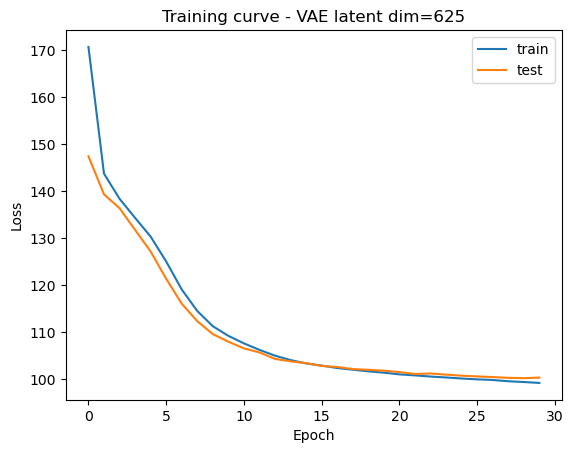

In [160]:
# N_EPOCHS_VAE = 70
N_EPOCHS_VAE = 30

for n_dims in DST_DIMS:
# for n_dims in [10, 50, 400]:
# for n_dims in [375]:
    print(f"### ndim={n_dims} ###")
    vae = VAE(latent_dim=n_dims).to(device)
    vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
    train_vae(vae, vae_opt, train_loader, test_loader, N_EPOCHS_VAE)

### Load trained VAEs, evaluate and plot

Creating low-dim MNIST datasets...2,

/tmp/ipykernel_1382722/4267390675.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(f"saved_models/mnist_best_vae_dim_{n_dims}.pth", map_location=device)


4,6,8,10,15,20,50,400,done


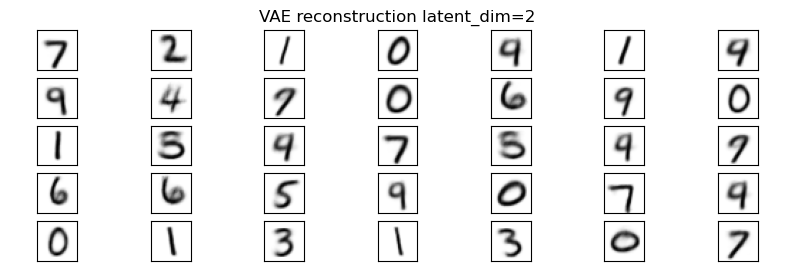

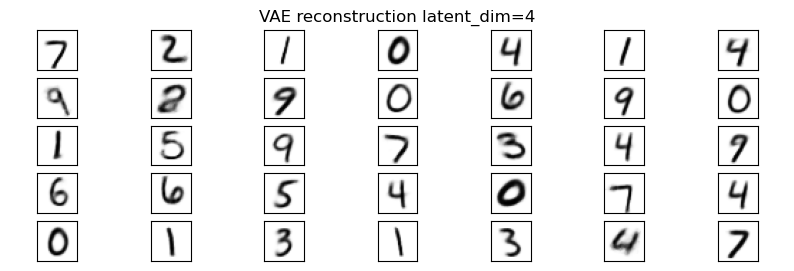

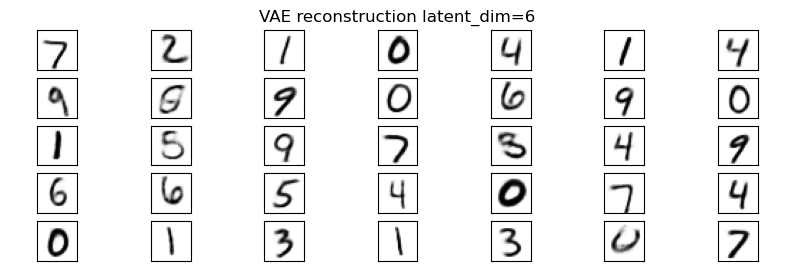

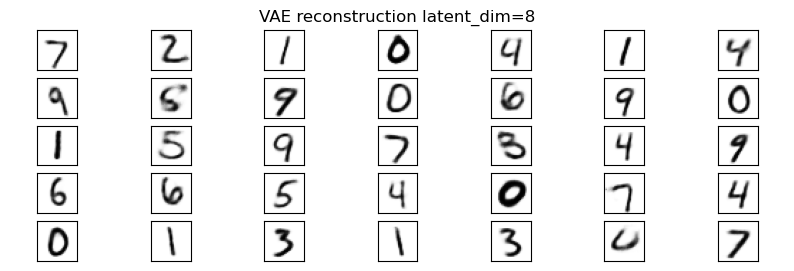

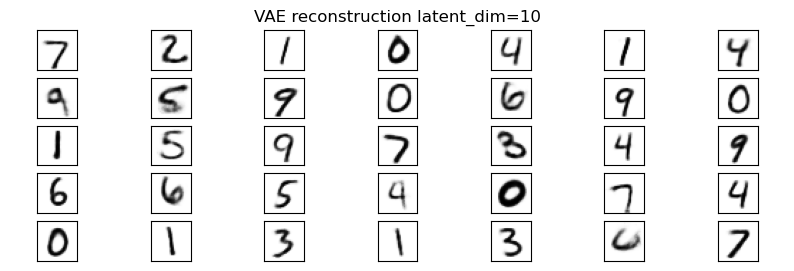

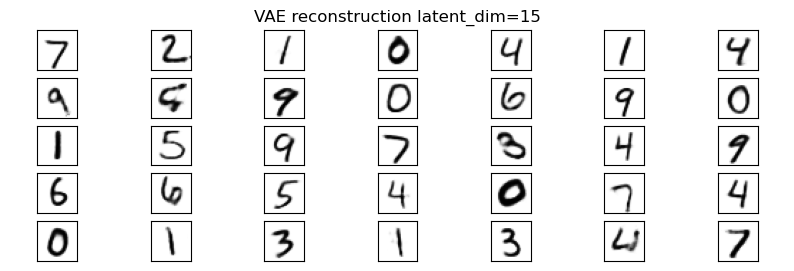

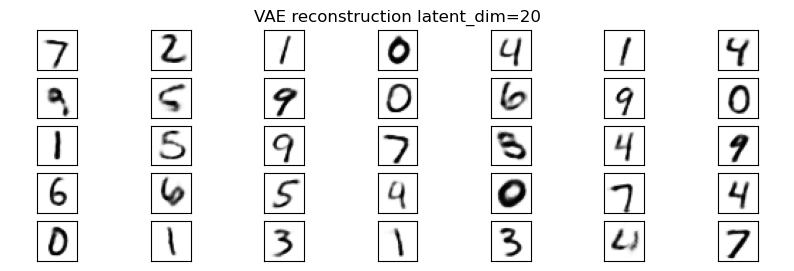

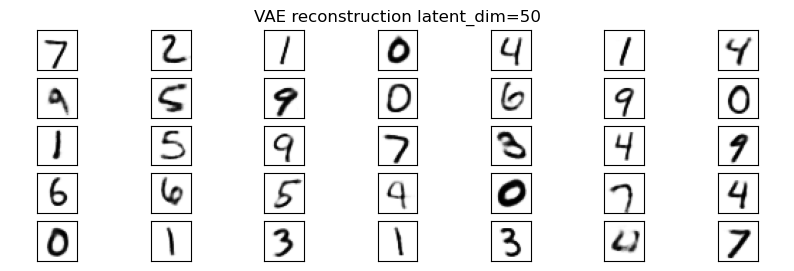

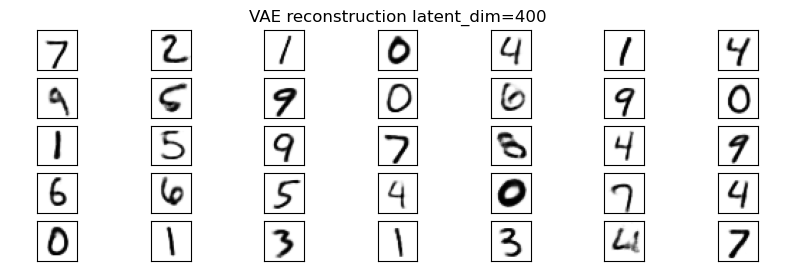

In [136]:
dsts_test_vae = dict.fromkeys(DST_DIMS)

print("Creating low-dim MNIST datasets...", end="")
for n_pcs in DST_DIMS:
# for n_dims in [2, 4, 6, 8, 10, 15, 20, 50, 400]:
    vae = torch.load(f"saved_models/mnist_best_vae_dim_{n_dims}.pth", map_location=device)
    vae.to(device)
    print(n_dims, end=",")

    all_images = all_test_images.view(-1, 784).to(device)

    recon_flat, mu, logvar, z = vae(all_images)
    
    # plot_image_samples(recon_flat.view(-1, 28, 28).cpu().detach().numpy(), 35, \
                       # fig_title=f"VAE reconstruction latent_dim={n_dims}")

    # vae_testset = TensorDataset(recon_flat, all_test_labels)
    # vae_testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    # #Save the testloader and trainloader for MNIST
    # dsts_test_vae[n_pcs] = vae_testloader
print("done")

In [161]:
def evaluate_vae_fixed_dim(vae, classifier, all_images, all_labels, device):
    classifier.eval()
    vae.eval()

    all_images = all_images.view(-1, 784).to(device)
    all_labels = all_labels.to(device)

    with torch.no_grad():
        recon_flat, mu, logvar, z = vae(all_images)
        recon_img = recon_flat.view(-1, 1, 28, 28)

        logits = classifier(recon_img)
        preds = logits.argmax(1)
        acc = (preds == all_labels).float().mean().item()
    return acc

VAE-  2 → Accuracy: 0.7809


/tmp/ipykernel_1382722/82397219.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(f"saved_models/mnist_best_vae_dim_{n_dims}.pth", map_location=device)


VAE-  4 → Accuracy: 0.9153
VAE-  6 → Accuracy: 0.9426
VAE-  8 → Accuracy: 0.9514
VAE- 10 → Accuracy: 0.9542
VAE- 15 → Accuracy: 0.9617
VAE- 20 → Accuracy: 0.9648
VAE- 25 → Accuracy: 0.9656
VAE- 30 → Accuracy: 0.9634
VAE- 35 → Accuracy: 0.9667
VAE- 40 → Accuracy: 0.9641
VAE- 45 → Accuracy: 0.9611
VAE- 50 → Accuracy: 0.9632
VAE- 60 → Accuracy: 0.9638
VAE- 70 → Accuracy: 0.9626
VAE- 80 → Accuracy: 0.9625
VAE- 90 → Accuracy: 0.9616
VAE-100 → Accuracy: 0.9653
VAE-120 → Accuracy: 0.9604
VAE-140 → Accuracy: 0.9597
VAE-160 → Accuracy: 0.9574
VAE-180 → Accuracy: 0.9650
VAE-200 → Accuracy: 0.9606
VAE-225 → Accuracy: 0.9631
VAE-250 → Accuracy: 0.9603
VAE-275 → Accuracy: 0.9624
VAE-300 → Accuracy: 0.9594
VAE-325 → Accuracy: 0.9581
VAE-350 → Accuracy: 0.9585
VAE-375 → Accuracy: 0.9573
VAE-400 → Accuracy: 0.9592
VAE-425 → Accuracy: 0.9597
VAE-450 → Accuracy: 0.9611
VAE-475 → Accuracy: 0.9600
VAE-500 → Accuracy: 0.9568
VAE-525 → Accuracy: 0.9546
VAE-550 → Accuracy: 0.9575
VAE-575 → Accuracy: 0.9577
V

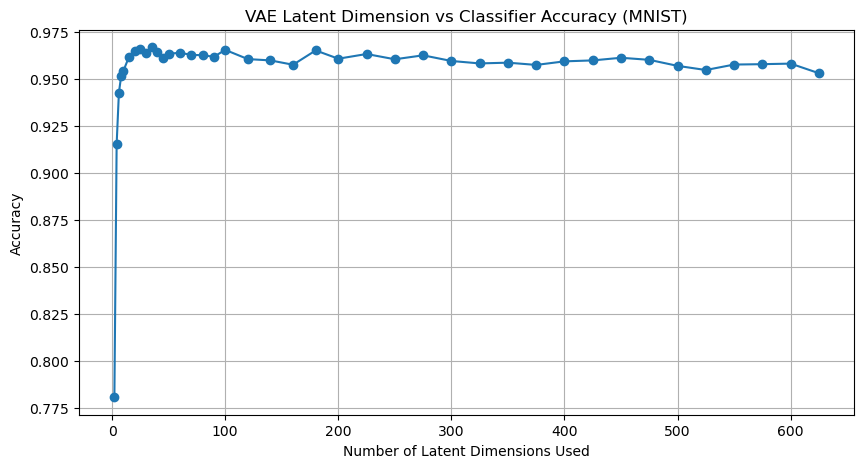

In [162]:
vae_eval_results = []
# TMP_DIMS = [2, 4, 6, 8, 10, 50, 300, 375, 400]
for n_dims in DST_DIMS:
# for n_dims in TMP_DIMS:
    vae = torch.load(f"saved_models/mnist_best_vae_dim_{n_dims}.pth", map_location=device)
    vae.to(device)
    
    vae_eval_acc = evaluate_vae_fixed_dim(
        vae=vae,
        classifier=cnn_classifier,  # Deepali's CNN loaded earlier
        all_images=all_test_images,
        all_labels=all_test_labels,
        device=device
    )
    vae_eval_results.append((n_dims, vae_eval_acc))
    print(f"VAE-{n_dims:>3} → Accuracy: {vae_eval_acc:.4f}")
vae_eval_results
# df_vae = pd.DataFrame(vae_eval_results, columns=["n_dims", "accuracy"])

plt.figure(figsize=(10, 5))
plt.plot(DST_DIMS, [acc for (_, acc) in vae_eval_results], '-o')
# plt.plot(TMP_DIMS, [acc for (_, acc) in vae_eval_results], '-o')
# sns.lineplot(data=df_vae, x="n_dims", y="accuracy", marker="o")
plt.title("VAE Latent Dimension vs Classifier Accuracy (MNIST)")
plt.xlabel("Number of Latent Dimensions Used")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

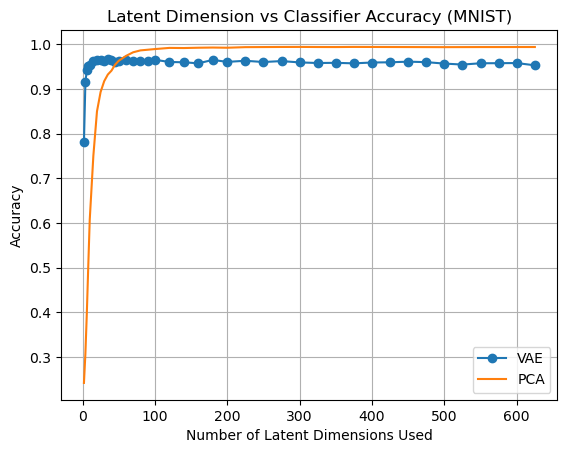

In [163]:
plt.plot(DST_DIMS, [acc for (_, acc) in vae_eval_results], '-o', label='VAE')
# plt.plot(TMP_DIMS, [acc for (_, acc) in vae_eval_results], '-o', label='VAE')
plt.plot(DST_DIMS, [acc for (_, acc) in pca_eval_results], '-', label='PCA')
plt.legend()
plt.title("Latent Dimension vs Classifier Accuracy (MNIST)")
plt.xlabel("Number of Latent Dimensions Used")
plt.ylabel("Accuracy")
plt.grid(True)